In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import to_categorical, img_to_array, load_img
import numpy as np


In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="hZmjLtF5i9Zeoiud7xiW")
project = rf.workspace("doan-ddo49").project("doan2-vx1ta")
version = project.version(2)
dataset = version.download("tensorflow")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to DoAn2-2 in tensorflow:: 100%|██████████████████████| 77/77 [00:00<00:00, 2710.00it/s]


In [2]:


# Load annotations
train_annotations = pd.read_csv('F:/gpu-env/Data-2/train/_annotations.csv')
valid_annotations = pd.read_csv('F:/gpu-env/Data-2/valid/_annotations.csv')

# Define U-net model
def unet_model():
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    up6 = concatenate([up6, drop4], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    
    return model

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

def process_coordinates(dataframe):
    return dataframe[['xmin', 'ymin', 'xmax', 'ymax']].values

label_map = {'Pencil_Sharpener': 0, 'Scissors': 1, 'Pen': 2, 'Ruler': 3, 'Eraser': 4}
# Convert labels to binary format
train_annotations['class'] = train_annotations['class'].map(label_map)
valid_annotations['class'] = valid_annotations['class'].map(label_map)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_annotations,
    directory='F:/gpu-env/Data-2/train/',
    x_col='filename',
    y_col='class',  
    target_size=(224, 224),
    batch_size=4,
    class_mode='input',  # Sử dụng 'input' để trả về ảnh gốc và nhãn
    seed=42
)


# Valid generator
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_annotations,
    directory='F:/gpu-env/Data-2/valid/',
    x_col='filename',
    y_col='class',  
    target_size=(224, 224),
    batch_size=4,
    class_mode='input',  # Sử dụng 'input' để trả về ảnh gốc và nhãn
    seed=42
)

# Compile model
model = unet_model()
model.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('unet_segmentation.keras', monitor='val_loss', save_best_only=True)

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // valid_generator.batch_size,
    callbacks=[checkpoint]
)


# Save model
model.save('unet_segmentation_final.h5')


Found 99 validated image filenames.
Found 101 validated image filenames.
Epoch 1/50
24/24 [==============================] - 30s 777ms/step - loss: 0.5530 - accuracy: 0.1758 - val_loss: 0.5263 - val_accuracy: 0.1969
Epoch 2/50
24/24 [==============================] - 11s 474ms/step - loss: 0.4608 - accuracy: 0.2083 - val_loss: 0.4472 - val_accuracy: 0.1968
Epoch 3/50
24/24 [==============================] - 11s 484ms/step - loss: 0.4374 - accuracy: 0.2028 - val_loss: 0.4268 - val_accuracy: 0.1969
Epoch 4/50
24/24 [==============================] - 11s 462ms/step - loss: 0.4495 - accuracy: 0.1958 - val_loss: 0.4300 - val_accuracy: 0.1970
Epoch 5/50
24/24 [==============================] - 12s 491ms/step - loss: 0.4320 - accuracy: 0.1981 - val_loss: 0.4182 - val_accuracy: 0.1970
Epoch 6/50
24/24 [==============================] - 11s 484ms/step - loss: 0.4231 - accuracy: 0.2027 - val_loss: 0.4178 - val_accuracy: 0.1971
Epoch 7/50
24/24 [==============================] - 12s 489ms/step - 

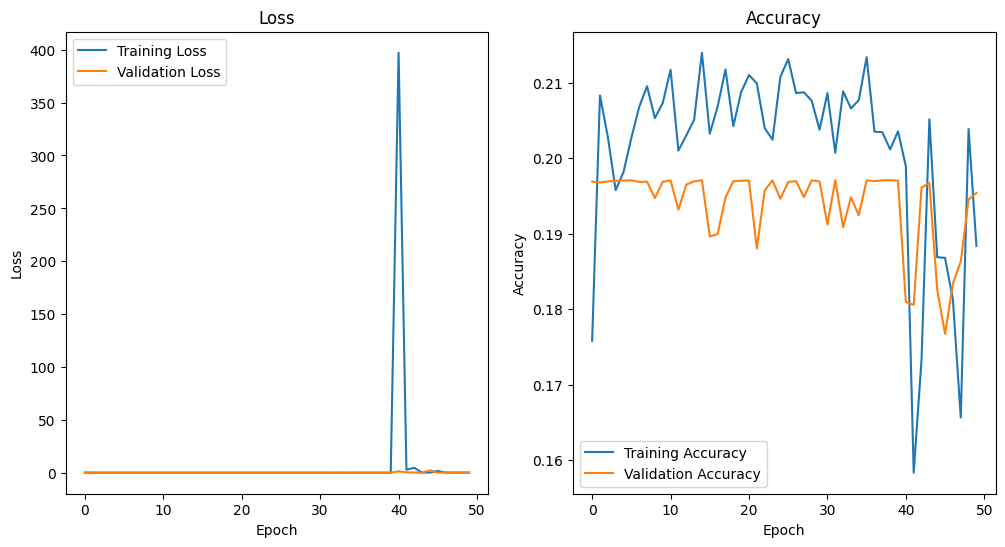

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
from PIL import Image
from keras.models import load_model
# Load and preprocess an arbitrary image
image_path = "F:/gpu-env/Data-2/test/photo1673015361-3-_jpeg_jpg.rf.30e27050a34d7da1120c92efb9f0b2d7.jpg"
img = Image.open(image_path)
img = img.resize((224, 224))  # Resize the image to match the input size of your model
img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

model = load_model('unet_segmentation_final.keras')
predictions = model.predict(img_array)

# Threshold the predictions (assuming binary segmentation)
threshold = 0.3
binary_predictions = (predictions > threshold).astype(np.uint8)

# Visualize the original image and predicted segmentation mask
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Predicted segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(binary_predictions))
plt.title("Predicted Segmentation Mask")
plt.axis("off")

plt.show()


1/1 [==============================] - 4s 4s/step


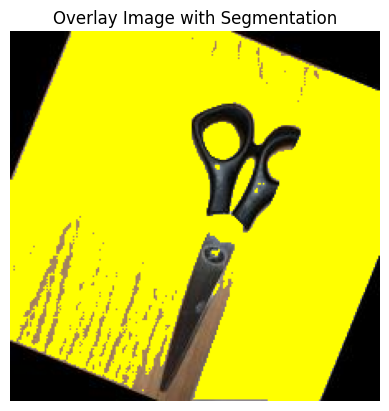

In [1]:
from PIL import Image
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess an arbitrary image
image_path = "F:/gpu-env/Data-2/test/photo1673015361-3-_jpeg_jpg.rf.30e27050a34d7da1120c92efb9f0b2d7.jpg"
img = Image.open(image_path)
img = img.resize((224, 224))  # Resize the image to match the input size of your model
img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

model = load_model('unet_segmentation_final.keras')
predictions = model.predict(img_array)

# Threshold the predictions (assuming binary segmentation)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.uint8)

# Create RGBA image for segmentation overlay
overlay_img = img.convert("RGBA")

# Set yellow color (RGBA)
yellow_color = [255, 255, 0]  # Yellow color without alpha value

# Apply segmentation mask to the overlay image
overlay_mask = binary_predictions[0] * 255  # Convert mask to 0-255 range
overlay_mask = np.squeeze(overlay_mask, axis=-1)  # Remove singleton dimension
overlay_mask_rgba = np.zeros((224, 224, 4), dtype=np.uint8)
overlay_mask_rgba[..., :3] = np.array(yellow_color)  # Set RGB channels to yellow color
overlay_mask_rgba[..., 3] = overlay_mask  # Set alpha channel based on predictions

# Create Image from array and paste it onto the overlay image
segmentation_overlay = Image.fromarray(overlay_mask_rgba, mode='RGBA')
overlay_img.paste(segmentation_overlay, (0, 0), segmentation_overlay)

# Display the overlay image
plt.imshow(overlay_img)
plt.axis("off")
plt.title("Overlay Image with Segmentation")
plt.show()


1/1 [==============================] - 0s 21ms/step


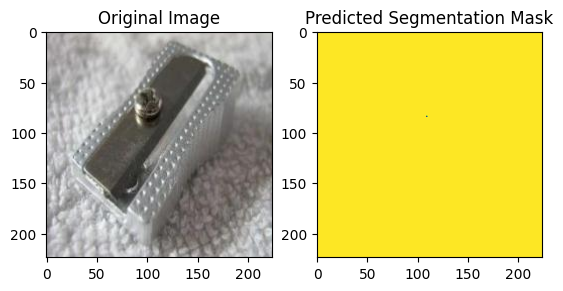

In [8]:
image_path = 'F:/gpu-env/Data-2/valid/12W4EQEW8MY2_jpg.rf.445b34063adfebc90e8e35ae5626795b.jpg'

# Mở và chuyển đổi hình ảnh thành mảng numpy
test_image = np.array(Image.open(image_path))

# Mở rộng kích thước của hình ảnh để phù hợp với đầu vào của mô hình
test_image = np.expand_dims(test_image, axis=0)

# Dự đoán mặt nạ phân đoạn cho hình ảnh
predicted_mask = model.predict(test_image)

# Loại bỏ kích thước thêm vào
predicted_mask = np.squeeze(predicted_mask, axis=0)

# Hiển thị hình ảnh gốc và mặt nạ dự đoán
fig, ax = plt.subplots(1, 2)
ax[0].imshow(test_image[0])
ax[0].title.set_text('Original Image')
channel = 0
ax[1].imshow(predicted_mask[..., channel])
ax[1].title.set_text('Predicted Segmentation Mask')
plt.show()